In [1]:
!pip install bertopic

In [19]:
!pip install sentence-transformers

#**Loading the Data**

In [2]:
# Access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import pandas
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/grants.csv'
df = pd.read_csv(file_path)

# Display the first few rows
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Unnamed: 0,opportunity_id,opportunity_title,opportunity_number,opportunity_category,funding_instrument_type,category_of_funding_activity,cfda_numbers,eligible_applicants,eligible_applicants_type,...,post_date,close_date,last_updated_date,archive_date,award_ceiling,award_floor,estimated_total_program_funding,expected_number_of_awards,cost_sharing_or_matching_requirement,additional_information_url
0,0,262148,Establishment of the Edmund S. Muskie Graduate...,SCAPPD-14-AW-161-SCA-08152014,Discretionary,Cooperative Agreement,Other,19.040,Others,Non-Government Organization,...,2014-08-15,2014-09-04,2014-08-20,2014-10-04,600000.0,400000.0,600000.0,1.0,False,NaN
1,1,262308,Health and resiliency of salt marshes in Jamai...,NPS-14-NERO-0119,Discretionary,Cooperative Agreement,Other,15.945,Others,Non-Government Organization,...,2014-08-18,2014-08-23,2014-08-18,2014-08-24,275897.0,275897.0,275897.0,1.0,False,NaN
2,2,262368,Post-Hurricane Sandy submerged marine habitat ...,NPS-14-NERO-0125,Discretionary,Cooperative Agreement,Other,15.945,Others,Non-Government Organization,...,2014-08-19,2014-08-24,2014-08-19,2014-08-25,480000.0,480000.0,480000.0,1.0,False,NaN
3,3,262390,Inventory and Monitoring of Amphibians and Rep...,NPS-14-NERO-0087,Discretionary,Cooperative Agreement,Other,15.945,Others,Non-Government Organization,...,2014-08-19,2014-08-24,2014-08-19,2014-08-25,255577.0,255577.0,255577.0,1.0,False,NaN
4,4,131594,Youth Leadership Program with Algeria,ECA-PE-C-PY-12-09,Discretionary,Cooperative Agreement,Other,19.415,Others,Non-Government Organization,...,2011-11-21,2012-01-04,2011-11-21,2012-01-05,250000.0,NaN,250000.0,1.0,True,http://exchanges.state.gov/grants/open2.html


#**Preprocessing**

In [4]:
# Import the necessary modules
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Drop rows with missing values in the relevant columns
df = df.dropna(subset=['opportunity_title', 'category_of_funding_activity'])

# Define the features and target
texts = df['opportunity_title'].astype(str).values
labels = df['category_of_funding_activity'].astype(str).values

# Tokenize and convert text to sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to ensure uniform input size
max_sequence_length = 150  # average title length
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Number of categories: {len(label_encoder.classes_)}")


Training samples: 60512, Testing samples: 15128
Number of categories: 26


#**RNN Model**

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,          # Stop after 3 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

# Define an improved model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length),
    LSTM(64, return_sequences=False),
    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1891/1891 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2019 - loss: 3.1987 - val_accuracy: 0.4503 - val_loss: 2.0744
Epoch 2/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4184 - loss: 2.0682 - val_accuracy: 0.5282 - val_loss: 1.7143
Epoch 3/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5258 - loss: 1.7360 - val_accuracy: 0.5912 - val_loss: 1.5389
Epoch 4/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5849 - loss: 1.5543 - val_accuracy: 0.6226 - val_loss: 1.4328
Epoch 5/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.6182 - loss: 1.4386 - val_accuracy: 0.6341 - val_loss: 1.3723
Epoch 6/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6407 - loss: 1.3450 - val_accuracy: 0.6413 - val_loss: 1.3189
Epoch 7/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6524 - loss: 1.2874 - val_accuracy: 0.6493 - val_loss: 1.2870
Epoch 8/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6667 - loss: 1.2323 - val

#**Visualize Training Progress**

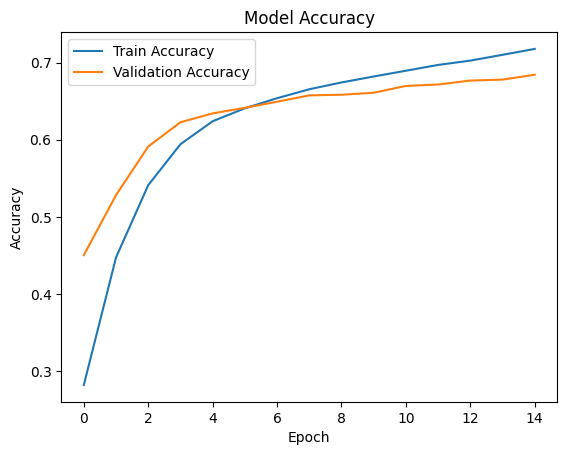

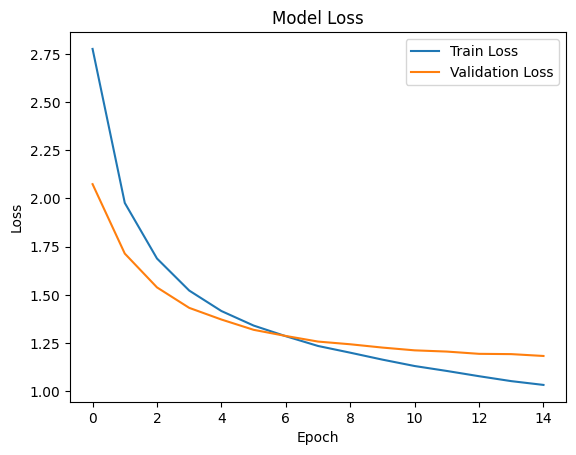

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


#**Evaluating the model**

In [7]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predict on new data
sample_titles = ["Improving healthcare access in rural areas", "Climate resilience research funding"]
sample_sequences = tokenizer.texts_to_sequences(sample_titles)
sample_padded = pad_sequences(sample_sequences, maxlen=max_sequence_length)
predictions = model.predict(sample_padded)
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))

for title, category in zip(sample_titles, predicted_categories):
    print(f"Title: {title}\nPredicted Category: {category}\n")


473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6788 - loss: 1.1939
Test Loss: 1.1832, Test Accuracy: 0.6842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Title: Improving healthcare access in rural areas
Predicted Category: Health

Title: Climate resilience research funding
Predicted Category: Science and Technology and other Research and Development



#**Extended Evaluation**

In [8]:
# Define additional sample titles
sample_titles = [
    "Improving healthcare access in rural areas",
    "Climate resilience research funding",
    "Educational opportunities for underprivileged youth",
    "Research on renewable energy technologies",
    "Community safety and crime prevention programs",
    "Innovations in agricultural practices",
    "Advancements in artificial intelligence",
    "Support for small business development",
    "Ocean and marine life conservation projects",
    "Healthcare innovations for low-income communities"
]

# Tokenize and pad the sample titles
sample_sequences = tokenizer.texts_to_sequences(sample_titles)
sample_padded = pad_sequences(sample_sequences, maxlen=max_sequence_length)

# Predict categories for the sample titles
predictions = model.predict(sample_padded)
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Display the results
for title, category in zip(sample_titles, predicted_categories):
    print(f"Title: {title}\nPredicted Category: {category}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Title: Improving healthcare access in rural areas
Predicted Category: Health

Title: Climate resilience research funding
Predicted Category: Science and Technology and other Research and Development

Title: Educational opportunities for underprivileged youth
Predicted Category: Education

Title: Research on renewable energy technologies
Predicted Category: Science and Technology and other Research and Development

Title: Community safety and crime prevention programs
Predicted Category: Law, Justice and Legal Services

Title: Innovations in agricultural practices
Predicted Category: Science and Technology and other Research and Development

Title: Advancements in artificial intelligence
Predicted Category: Science and Technology and other Research and Development

Title: Support for small business development
Predicted Category: Other

Title: Ocean and marine life conservation projects
Predicted Category: Science and Technology and other Research 

#**Validating Predictions Against Ground Truth**

In [9]:
from sklearn.metrics import classification_report, accuracy_score

# Generate predictions for the test dataset
test_predictions = model.predict(X_test)
predicted_indices = test_predictions.argmax(axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_indices)

# Convert ground truth labels (y_test) back to their category names
true_labels = label_encoder.inverse_transform(y_test)

# Compare predictions to ground truth
print("Validation Results:")
print(f"Accuracy: {accuracy_score(true_labels, predicted_labels):.4f}")

# Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))


473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation Results:
Accuracy: 0.6842

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                           precision    recall  f1-score   support

                                      Affordable Care Act       0.00      0.00      0.00        22
                                              Agriculture       0.44      0.03      0.06       221
                                                     Arts       0.00      0.00      0.00        85
                                    Business and Commerce       0.00      0.00      0.00        78
                                    Community Development       0.00      0.00      0.00       161
                                      Consumer Protection       0.00      0.00      0.00         6
                           Disaster Prevention and Relief       0.00      0.00      0.00        63
                                                Education       0.64      0.59      0.61       825
                           Employment, Labor and Training       0.00      0.00      0.00       191
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#**Save Model**

In [10]:
# Save the model and tokenizer
model.save('rnn_funding_category_model_2.5.h5')

import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


#**BERTopic Model**


In [12]:
from bertopic import BERTopic
import pandas as pd

# Fit BERTopic on the data
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df['opportunity_title'].values)

# Display topic information
topic_info = topic_model.get_topic_info()
print("Topic Info:")
print(topic_info)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Topic Info:
      Topic  Count                                               Name  \
0        -1  19525                          -1_park_river_at_monument   
1         0    331                     0_pas_statement_embassy_annual   
2         1    297                      1_recreation_blm_visitor_orwa   
3         2    237                 2_trail_trails_rehabilitate_repair   
4         3    233            3_innovation_cig_conservation_hampshire   
...     ...    ...                                                ...   
2007   2006     10  2006_radiobiology_groundbased_radiochemistry_s...   
2008   2007     10         2007_cardiac_subtypes_heartshare_phenomics   
2009   2008     10        2008_faslp_agriculture_learning_foodservice   
2010   2009     10                2009_african_culture_museum_history   
2011   2010     10           2010_washington_kittitas_seattle_clallam   

                                         Representation  \
0     [park, river, at, monument, drl, information, 

In [13]:
# Visualize topics
topic_model.visualize_topics()


Output hidden; open in https://colab.research.google.com to view.

In [15]:
# Display the BERTopic topics and their keywords
for topic_id in range(len(topic_model.get_topic_info())):
    print(f"Topic {topic_id}: {topic_model.get_topic(topic_id)}")


Categories from the RNN model:
['Affordable Care Act' 'Agriculture' 'Arts' 'Business and Commerce'
 'Community Development' 'Consumer Protection'
 'Disaster Prevention and Relief' 'Education'
 'Employment, Labor and Training' 'Energy' 'Environment'
 'Food and Nutrition' 'Health' 'Housing' 'Humanities'
 'Income Security and Social Services' 'Information and Statistics'
 'Infrastructure Investment and Jobs Act'
 'Law, Justice and Legal Services' 'Natural Resources'
 'Opportunity Zone Benefits' 'Other' 'Recovery Act' 'Regional Development'
 'Science and Technology and other Research and Development'
 'Transportation']
Topic 0: [('pas', 0.05147208998977456), ('statement', 0.0491171615411375), ('embassy', 0.046796172066203304), ('annual', 0.04466051969089154), ('pds', 0.025943517366239933), ('us', 0.02484440009559222), ('consulate', 0.024686600360816453), ('affairs', 0.023437795958837368), ('section', 0.015651836373564786), ('diplomacy', 0.014699331263903114)]
Topic 1: [('recreation', 0.024

In [20]:
# Retrieve the RNN categories
rnn_categories = label_encoder.classes_
print("Categories from the RNN model:")
print(rnn_categories)


Categories from the RNN model:
['Affordable Care Act' 'Agriculture' 'Arts' 'Business and Commerce'
 'Community Development' 'Consumer Protection'
 'Disaster Prevention and Relief' 'Education'
 'Employment, Labor and Training' 'Energy' 'Environment'
 'Food and Nutrition' 'Health' 'Housing' 'Humanities'
 'Income Security and Social Services' 'Information and Statistics'
 'Infrastructure Investment and Jobs Act'
 'Law, Justice and Legal Services' 'Natural Resources'
 'Opportunity Zone Benefits' 'Other' 'Recovery Act' 'Regional Development'
 'Science and Technology and other Research and Development'
 'Transportation']


In [34]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from IPython.display import display

# Load the dataset
file_path = '/content/drive/MyDrive/grants.csv'
df = pd.read_csv(file_path)
df = df.dropna(subset=['opportunity_title'])
df['opportunity_title'] = df['opportunity_title'].astype(str)

# Preprocess text by removing stopwords
custom_stopwords = set(["grant", "funding", "application"])
stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords)

def preprocess_text(text):
    return ' '.join([word for word in text.split() if word.lower() not in stopwords])

df['cleaned_opportunity_title'] = df['opportunity_title'].apply(preprocess_text)

# Define RNN categories
rnn_categories = label_encoder.classes_
print("RNN Categories:", rnn_categories)

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=embedding_model, min_topic_size=50)

# Fit BERTopic
topics, probs = topic_model.fit_transform(df['cleaned_opportunity_title'].values)

# Reduce topics to align better with RNN categories
topic_model.reduce_topics(df['cleaned_opportunity_title'], nr_topics=len(rnn_categories))

# Visualize reduced topics (optional, for exploration)
topic_model.visualize_topics()

# Automated mapping using sentence embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for RNN categories
category_embeddings = model.encode(rnn_categories)

# Generate embeddings for reduced BERTopic keywords
topic_keywords = []
for topic_id in range(len(topic_model.get_topic_info())):
    keywords = topic_model.get_topic(topic_id)
    if keywords:
        topic_keywords.append(', '.join([word for word, _ in keywords]))
    else:
        topic_keywords.append('')

# Generate embeddings for the topics
topic_embeddings = model.encode(topic_keywords)

# Map reduced topics to RNN categories using cosine similarity
mapped_categories = {}
for topic_id, topic_embedding in enumerate(topic_embeddings):
    if topic_keywords[topic_id] != "":
        similarities = util.cos_sim(topic_embedding, category_embeddings).squeeze()
        best_match = similarities.argmax().item()
        mapped_categories[topic_id] = rnn_categories[best_match]
    else:
        mapped_categories[topic_id] = "Uncategorized"

print("Mapped Categories:", mapped_categories)

# Apply mapping to the dataset
df['bert_topic'] = topic_model.get_document_info(df['cleaned_opportunity_title'])['Topic']
df['mapped_category'] = df['bert_topic'].map(mapped_categories)

# Drop rows with missing values in evaluation columns
df = df.dropna(subset=['category_of_funding_activity', 'mapped_category'])

# Ensure labels are strings
true_labels = df['category_of_funding_activity'].astype(str)
predicted_labels = df['mapped_category'].astype(str)

# Evaluate BERTopic performance
print("BERTopic Evaluation:")
print(f"Accuracy: {accuracy_score(true_labels, predicted_labels):.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

# Visualize topic-word distribution
barchart = topic_model.visualize_barchart()
display(barchart)

# Save topics and mappings for analysis
df[['opportunity_title', 'bert_topic', 'mapped_category']].to_csv("bert_topic_mapping.csv", index=False)


RNN Categories: ['Affordable Care Act' 'Agriculture' 'Arts' 'Business and Commerce'
 'Community Development' 'Consumer Protection'
 'Disaster Prevention and Relief' 'Education'
 'Employment, Labor and Training' 'Energy' 'Environment'
 'Food and Nutrition' 'Health' 'Housing' 'Humanities'
 'Income Security and Social Services' 'Information and Statistics'
 'Infrastructure Investment and Jobs Act'
 'Law, Justice and Legal Services' 'Natural Resources'
 'Opportunity Zone Benefits' 'Other' 'Recovery Act' 'Regional Development'
 'Science and Technology and other Research and Development'
 'Transportation']
Mapped Categories: {0: 'Health', 1: 'Natural Resources', 2: 'Affordable Care Act', 3: 'Employment, Labor and Training', 4: 'Law, Justice and Legal Services', 5: 'Regional Development', 6: 'Science and Technology and other Research and Development', 7: 'Natural Resources', 8: 'Health', 9: 'Transportation', 10: 'Environment', 11: 'Law, Justice and Legal Services', 12: 'Information and Statis

In [35]:
print("RNN Accuracy: 0.6800")
print(f"BERTopic Accuracy: {accuracy_score(true_labels, predicted_labels):.4f}")


RNN Accuracy: 0.6800
BERTopic Accuracy: 0.4109
